# Обнаружение аномалий во временных рядах

Обнаружение аномалий с помощью статистических порогов и Isolation Forest

Этот ноутбук содержит теоретическую часть, практическую реализацию и задания для самостоятельной работы. Код написан на Python и готов для запуска в Jupyter Notebook.


## 1. Введение в обнаружение аномалий

Аномалии (выбросы) — это точки данных, которые значительно отличаются от большинства других наблюдений. В контексте временных рядов аномалии могут быть:

- **Точечные аномалии** — отдельные выбросы  
- **Контекстуальные аномалии** — нормальные в общем, но аномальные в конкретном контексте  
- **Коллективные аномалии** — группа точек, аномальная как коллектив

## 2. Методы обнаружения аномалий

### 2.1 Статистические пороговые методы

- Основаны на предположении о нормальном распределении данных  
- Используют z-score, IQR (межквартильный размах), скользящие статистики  
- Простые в реализации и интерпретации  
- Эффективны для одномерных данных

### 2.2 Isolation Forest

- Алгоритм машинного обучения для обнаружения аномалий  
- Основан на идее, что аномалии — редкие и разные  
- Строит деревья изоляции, случайно выбирая признаки и точки разделения  
- Аномалии изолируются быстрее (требуют меньше разделений)

## 3. Применение в реальном мире

- Мониторинг систем (IT, промышленность)  
- Обнаружение мошенничества  
- Анализ медицинских данных  
- Прогнозирование отказов оборудования


In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Настройка отображения графиков
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12

# Генерация случайных данных для воспроизводимости
np.random.seed(42)


# 1. Генерация синтетических данных временного ряда

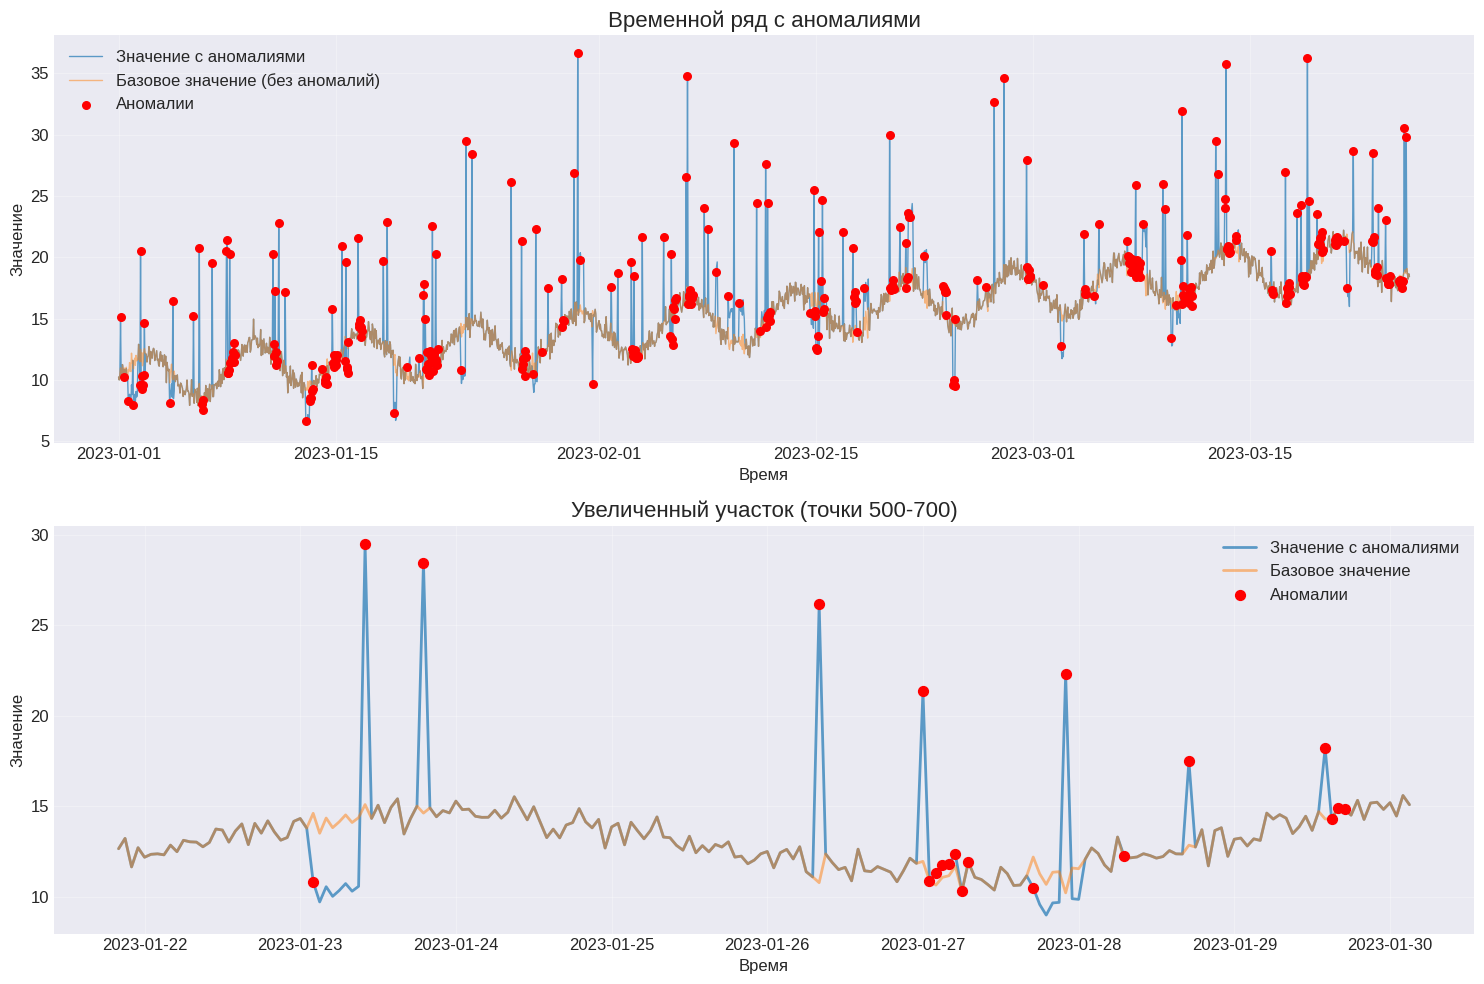

Статистика по сгенерированным данным:
Всего точек: 2000
Количество аномалий: 369
Доля аномалий: 18.45%
Среднее значение: 15.39
Стандартное отклонение: 3.89
Минимальное значение: 6.42
Максимальное значение: 36.62


In [2]:
def generate_time_series_data(n_points=1000, anomaly_ratio=0.05, trend_strength=0.01,
                              seasonality_period=100, noise_level=0.5):
    """
    Генерация синтетических данных временного ряда с аномалиями

    Параметры:
    n_points: количество точек данных
    anomaly_ratio: доля аномалий в данных
    trend_strength: сила тренда
    seasonality_period: период сезонности
    noise_level: уровень шума
    """
    # Базовый временной ряд
    time_index = pd.date_range(start='2023-01-01', periods=n_points, freq='H')

    # Тренд
    trend = trend_strength * np.arange(n_points)

    # Сезонность
    seasonality = 2 * np.sin(2 * np.pi * np.arange(n_points) / seasonality_period)

    # Случайный шум
    noise = noise_level * np.random.randn(n_points)

    # Базовое значение
    base_value = 10 + trend + seasonality + noise

    # Добавление аномалий
    n_anomalies = int(n_points * anomaly_ratio)
    anomaly_indices = np.random.choice(n_points, size=n_anomalies, replace=False)

    # Создаем копию базовых данных
    data_with_anomalies = base_value.copy()

    # Добавляем аномалии разных типов
    for idx in anomaly_indices:
        anomaly_type = np.random.choice(['spike', 'dip', 'shift'])

        if anomaly_type == 'spike':
            # Положительный выброс
            data_with_anomalies[idx] += 5 * np.random.randn() + 10
        elif anomaly_type == 'dip':
            # Отрицательный выброс
            data_with_anomalies[idx] -= 5 * np.abs(np.random.randn()) - 10
        else:
            # Сдвиг уровня
            shift_duration = np.random.randint(3, 10)
            shift_magnitude = 3 * np.random.randn()
            end_idx = min(idx + shift_duration, n_points)
            data_with_anomalies[idx:end_idx] += shift_magnitude

    # Создаем метки аномалий
    anomaly_labels = np.zeros(n_points, dtype=int)
    anomaly_labels[anomaly_indices] = 1

    # Для сдвигов уровня помечаем все точки сдвига как аномалии
    for idx in anomaly_indices:
        anomaly_type = np.random.choice(['spike', 'dip', 'shift'])
        if anomaly_type == 'shift':
            shift_duration = np.random.randint(3, 10)
            end_idx = min(idx + shift_duration, n_points)
            anomaly_labels[idx:end_idx] = 1

    # Создаем DataFrame
    df = pd.DataFrame({
        'timestamp': time_index,
        'value': data_with_anomalies,
        'base_value': base_value,
        'anomaly': anomaly_labels
    })

    return df

# Генерация данных
df = generate_time_series_data(n_points=2000, anomaly_ratio=0.07,
                               trend_strength=0.005, seasonality_period=168)  # недельная сезонность

# Визуализация данных
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Полный временной ряд
axes[0].plot(df['timestamp'], df['value'], label='Значение с аномалиями', alpha=0.7, linewidth=1)
axes[0].plot(df['timestamp'], df['base_value'], label='Базовое значение (без аномалий)',
            alpha=0.5, linewidth=1)
axes[0].scatter(df[df['anomaly'] == 1]['timestamp'],
               df[df['anomaly'] == 1]['value'],
               color='red', s=30, label='Аномалии', zorder=5)
axes[0].set_title('Временной ряд с аномалиями', fontsize=16)
axes[0].set_xlabel('Время')
axes[0].set_ylabel('Значение')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Увеличенный участок
sample_start = 500
sample_end = 700
df_sample = df.iloc[sample_start:sample_end]

axes[1].plot(df_sample['timestamp'], df_sample['value'], label='Значение с аномалиями',
            alpha=0.7, linewidth=2)
axes[1].plot(df_sample['timestamp'], df_sample['base_value'], label='Базовое значение',
            alpha=0.5, linewidth=2)
axes[1].scatter(df_sample[df_sample['anomaly'] == 1]['timestamp'],
               df_sample[df_sample['anomaly'] == 1]['value'],
               color='red', s=50, label='Аномалии', zorder=5)
axes[1].set_title(f'Увеличенный участок (точки {sample_start}-{sample_end})', fontsize=16)
axes[1].set_xlabel('Время')
axes[1].set_ylabel('Значение')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Статистика по данным
print("Статистика по сгенерированным данным:")
print(f"Всего точек: {len(df)}")
print(f"Количество аномалий: {df['anomaly'].sum()}")
print(f"Доля аномалий: {df['anomaly'].sum()/len(df):.2%}")
print(f"Среднее значение: {df['value'].mean():.2f}")
print(f"Стандартное отклонение: {df['value'].std():.2f}")
print(f"Минимальное значение: {df['value'].min():.2f}")
print(f"Максимальное значение: {df['value'].max():.2f}")

# 2. Обнаружение аномалий с помощью статистических порогов
# 2.1 Метод Z-score

In [ ]:
def detect_anomalies_zscore(data, window_size=24, threshold=3):
    """
    Обнаружение аномалий с помощью скользящего Z-score

    Параметры:
    data: временной ряд
    window_size: размер окна для скользящей статистики
    threshold: пороговое значение Z-score для обнаружения аномалий
    """
    # Скользящее среднее и стандартное отклонение
    rolling_mean = data.rolling(window=window_size, center=True, min_periods=1).mean()
    rolling_std = data.rolling(window=window_size, center=True, min_periods=1).std()

    # Z-score
    z_scores = np.abs((data - rolling_mean) / (rolling_std + 1e-10))  # Добавляем небольшое значение для избежания деления на 0

    # Метки аномалий
    anomalies = (z_scores > threshold).astype(int)

    return z_scores, anomalies

# Применение метода Z-score
z_scores, z_anomalies = detect_anomalies_zscore(df['value'], window_size=24, threshold=3)

# Добавление результатов в DataFrame
df['z_score'] = z_scores
df['z_anomaly_pred'] = z_anomalies

# Визуализация результатов
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Временной ряд с предсказанными аномалиями
axes[0].plot(df['timestamp'], df['value'], label='Временной ряд', alpha=0.7, linewidth=1)
axes[0].scatter(df[df['z_anomaly_pred'] == 1]['timestamp'],
               df[df['z_anomaly_pred'] == 1]['value'],
               color='orange', s=30, label='Предсказанные аномалии (Z-score)', zorder=5)
axes[0].scatter(df[df['anomaly'] == 1]['timestamp'],
               df[df['anomaly'] == 1]['value'],
               color='red', s=20, alpha=0.5, label='Истинные аномалии', zorder=4)
axes[0].set_title('Обнаружение аномалий методом Z-score', fontsize=16)
axes[0].set_xlabel('Время')
axes[0].set_ylabel('Значение')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Z-score
axes[1].plot(df['timestamp'], df['z_score'], label='Z-score', color='green', alpha=0.7, linewidth=1)
axes[1].axhline(y=3, color='red', linestyle='--', label='Порог (Z=3)')
axes[1].fill_between(df['timestamp'], 3, df['z_score'].max(),
                     where=(df['z_score'] > 3), color='red', alpha=0.2)
axes[1].set_title('Z-score временного ряда', fontsize=16)
axes[1].set_xlabel('Время')
axes[1].set_ylabel('Z-score')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Увеличенный участок для детального рассмотрения
sample_start = 500
sample_end = 700
df_sample = df.iloc[sample_start:sample_end]

axes[2].plot(df_sample['timestamp'], df_sample['value'], label='Временной ряд', alpha=0.7, linewidth=2)
axes[2].scatter(df_sample[df_sample['z_anomaly_pred'] == 1]['timestamp'],
               df_sample[df_sample['z_anomaly_pred'] == 1]['value'],
               color='orange', s=50, label='Предсказанные аномалии (Z-score)', zorder=5)
axes[2].scatter(df_sample[df_sample['anomaly'] == 1]['timestamp'],
               df_sample[df_sample['anomaly'] == 1]['value'],
               color='red', s=30, alpha=0.7, label='Истинные аномалии', zorder=4)
axes[2].set_title(f'Увеличенный участок (точки {sample_start}-{sample_end})', fontsize=16)
axes[2].set_xlabel('Время')
axes[2].set_ylabel('Значение')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Оценка качества метода Z-score
print("Оценка метода Z-score:")
print(classification_report(df['anomaly'], df['z_anomaly_pred'],
                           target_names=['Норма', 'Аномалия']))

# 2.2 Метод межквартильного размаха (IQR)

In [ ]:
def detect_anomalies_iqr(data, window_size=48, threshold=1.5):
    """
    Обнаружение аномалий с помощью скользящего межквартильного размаха (IQR)

    Параметры:
    data: временной ряд
    window_size: размер окна для скользящей статистики
    threshold: множитель IQR для определения границ
    """
    # Скользящие квантили
    rolling_q1 = data.rolling(window=window_size, center=True, min_periods=1).quantile(0.25)
    rolling_q3 = data.rolling(window=window_size, center=True, min_periods=1).quantile(0.75)

    # Межквартильный размах
    rolling_iqr = rolling_q3 - rolling_q1

    # Границы для обнаружения аномалий
    lower_bound = rolling_q1 - threshold * rolling_iqr
    upper_bound = rolling_q3 + threshold * rolling_iqr

    # Метки аномалий
    anomalies = ((data < lower_bound) | (data > upper_bound)).astype(int)

    return lower_bound, upper_bound, anomalies

# Применение метода IQR
lower_bound, upper_bound, iqr_anomalies = detect_anomalies_iqr(df['value'], window_size=48, threshold=1.5)

# Добавление результатов в DataFrame
df['lower_bound'] = lower_bound
df['upper_bound'] = upper_bound
df['iqr_anomaly_pred'] = iqr_anomalies

# Визуализация результатов
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Временной ряд с границами IQR
axes[0].plot(df['timestamp'], df['value'], label='Временной ряд', alpha=0.7, linewidth=1)
axes[0].fill_between(df['timestamp'], df['lower_bound'], df['upper_bound'],
                     alpha=0.3, color='green', label='Нормальный диапазон (IQR)')
axes[0].scatter(df[df['iqr_anomaly_pred'] == 1]['timestamp'],
               df[df['iqr_anomaly_pred'] == 1]['value'],
               color='purple', s=30, label='Предсказанные аномалии (IQR)', zorder=5)
axes[0].scatter(df[df['anomaly'] == 1]['timestamp'],
               df[df['anomaly'] == 1]['value'],
               color='red', s=20, alpha=0.5, label='Истинные аномалии', zorder=4)
axes[0].set_title('Обнаружение аномалий методом IQR', fontsize=16)
axes[0].set_xlabel('Время')
axes[0].set_ylabel('Значение')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Увеличенный участок
sample_start = 500
sample_end = 700
df_sample = df.iloc[sample_start:sample_end]

axes[1].plot(df_sample['timestamp'], df_sample['value'], label='Временной ряд',
            alpha=0.7, linewidth=2)
axes[1].fill_between(df_sample['timestamp'],
                     df_sample['lower_bound'],
                     df_sample['upper_bound'],
                     alpha=0.3, color='green', label='Нормальный диапазон (IQR)')
axes[1].scatter(df_sample[df_sample['iqr_anomaly_pred'] == 1]['timestamp'],
               df_sample[df_sample['iqr_anomaly_pred'] == 1]['value'],
               color='purple', s=50, label='Предсказанные аномалии (IQR)', zorder=5)
axes[1].scatter(df_sample[df_sample['anomaly'] == 1]['timestamp'],
               df_sample[df_sample['anomaly'] == 1]['value'],
               color='red', s=30, alpha=0.7, label='Истинные аномалии', zorder=4)
axes[1].set_title(f'Увеличенный участок (точки {sample_start}-{sample_end})', fontsize=16)
axes[1].set_xlabel('Время')
axes[1].set_ylabel('Значение')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Оценка качества метода IQR
print("Оценка метода IQR:")
print(classification_report(df['anomaly'], df['iqr_anomaly_pred'],
                           target_names=['Норма', 'Аномалия']))

# 3. Обнаружение аномалий с помощью Isolation Forest
# 3.1 Подготовка признаков для Isolation Forest

In [ ]:
def create_features_for_isolation_forest(series, window_sizes=[3, 6, 12, 24, 48]):
    """
    Создание признаков для Isolation Forest из временного ряда

    Параметры:
    series: исходный временной ряд
    window_sizes: размеры окон для создания статистических признаков
    """
    features = pd.DataFrame(index=series.index)

    # Базовые признаки
    features['value'] = series

    # Признаки на основе статистик за разные окна
    for window in window_sizes:
        # Скользящее среднее
        features[f'mean_{window}'] = series.rolling(window=window, min_periods=1).mean()

        # Скользящее стандартное отклонение
        features[f'std_{window}'] = series.rolling(window=window, min_periods=1).std()

        # Минимум и максимум
        features[f'min_{window}'] = series.rolling(window=window, min_periods=1).min()
        features[f'max_{window}'] = series.rolling(window=window, min_periods=1).max()

        # Размах (мах - мин)
        features[f'range_{window}'] = features[f'max_{window}'] - features[f'min_{window}']

    # Признаки тренда
    features['diff_1'] = series.diff(1)
    features['diff_3'] = series.diff(3)
    features['diff_12'] = series.diff(12)

    # Процентное изменение
    features['pct_change_1'] = series.pct_change(1)
    features['pct_change_3'] = series.pct_change(3)

    # Заполнение пропущенных значений (в начале ряда из-за diff)
    features = features.fillna(method='bfill').fillna(method='ffill')

    return features

# Создание признаков
features = create_features_for_isolation_forest(df['value'])

# Масштабирование признаков
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_features_df = pd.DataFrame(scaled_features, index=features.index, columns=features.columns)

print(f"Создано {features.shape[1]} признаков для Isolation Forest")
print("Первые 5 строк признаков:")
print(features.head())

# 3.2 Обучение и применение Isolation Forest

In [ ]:
def apply_isolation_forest(features, contamination=0.05, random_state=42):
    """
    Применение Isolation Forest для обнаружения аномалий

    Параметры:
    features: матрица признаков
    contamination: ожидаемая доля аномалий в данных
    random_state: seed для воспроизводимости
    """
    # Создание и обучение модели
    iso_forest = IsolationForest(
        n_estimators=100,
        max_samples='auto',
        contamination=contamination,
        max_features=1.0,
        bootstrap=False,
        random_state=random_state,
        n_jobs=-1
    )

    # Обучение модели
    iso_forest.fit(features)

    # Предсказание (1 = норма, -1 = аномалия)
    predictions = iso_forest.predict(features)

    # Преобразование в бинарные метки (0 = норма, 1 = аномалия)
    anomaly_predictions = (predictions == -1).astype(int)

    # Оценка аномальности (чем меньше, тем более аномальная точка)
    anomaly_scores = iso_forest.decision_function(features)

    return anomaly_predictions, anomaly_scores, iso_forest

# Применение Isolation Forest
if_anomalies, if_scores, iso_forest_model = apply_isolation_forest(
    scaled_features_df,
    contamination=0.07,  # Примерная доля аномалий в наших данных
    random_state=42
)

# Добавление результатов в DataFrame
df['if_anomaly_pred'] = if_anomalies
df['if_anomaly_score'] = if_scores

# Визуализация результатов
fig, axes = plt.subplots(3, 1, figsize=(15, 14))

# Временной ряд с предсказанными аномалиями
axes[0].plot(df['timestamp'], df['value'], label='Временной ряд', alpha=0.7, linewidth=1)
axes[0].scatter(df[df['if_anomaly_pred'] == 1]['timestamp'],
               df[df['if_anomaly_pred'] == 1]['value'],
               color='blue', s=30, label='Предсказанные аномалии (Isolation Forest)', zorder=5)
axes[0].scatter(df[df['anomaly'] == 1]['timestamp'],
               df[df['anomaly'] == 1]['value'],
               color='red', s=20, alpha=0.5, label='Истинные аномалии', zorder=4)
axes[0].set_title('Обнаружение аномалий с помощью Isolation Forest', fontsize=16)
axes[0].set_xlabel('Время')
axes[0].set_ylabel('Значение')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Оценки аномальности
axes[1].plot(df['timestamp'], df['if_anomaly_score'], label='Оценка аномальности',
            color='darkorange', alpha=0.7, linewidth=1)
axes[1].fill_between(df['timestamp'], df['if_anomaly_score'].min(), df['if_anomaly_score'],
                     where=(df['if_anomaly_pred'] == 1), color='blue', alpha=0.3, label='Предсказанные аномалии')
axes[1].set_title('Оценки аномальности Isolation Forest (чем меньше, тем более аномальная точка)', fontsize=16)
axes[1].set_xlabel('Время')
axes[1].set_ylabel('Оценка аномальности')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Увеличенный участок
sample_start = 500
sample_end = 700
df_sample = df.iloc[sample_start:sample_end]

axes[2].plot(df_sample['timestamp'], df_sample['value'], label='Временной ряд',
            alpha=0.7, linewidth=2)
axes[2].scatter(df_sample[df_sample['if_anomaly_pred'] == 1]['timestamp'],
               df_sample[df_sample['if_anomaly_pred'] == 1]['value'],
               color='blue', s=50, label='Предсказанные аномалии (Isolation Forest)', zorder=5)
axes[2].scatter(df_sample[df_sample['anomaly'] == 1]['timestamp'],
               df_sample[df_sample['anomaly'] == 1]['value'],
               color='red', s=30, alpha=0.7, label='Истинные аномалии', zorder=4)
axes[2].set_title(f'Увеличенный участок (точки {sample_start}-{sample_end})', fontsize=16)
axes[2].set_xlabel('Время')
axes[2].set_ylabel('Значение')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Оценка качества Isolation Forest
print("Оценка Isolation Forest:")
print(classification_report(df['anomaly'], df['if_anomaly_pred'],
                           target_names=['Норма', 'Аномалия']))

# Матрица ошибок для Isolation Forest
cm = confusion_matrix(df['anomaly'], df['if_anomaly_pred'])
cm_df = pd.DataFrame(cm, index=['Факт: Норма', 'Факт: Аномалия'],
                     columns=['Прогноз: Норма', 'Прогноз: Аномалия'])

print("Матрица ошибок Isolation Forest:")
print(cm_df)

# 4. Сравнение методов

In [ ]:
# Сравнение всех трех методов
fig, axes = plt.subplots(4, 1, figsize=(15, 16))

# Временной ряд с истинными аномалиями
axes[0].plot(df['timestamp'], df['value'], label='Временной ряд', alpha=0.7, linewidth=1)
axes[0].scatter(df[df['anomaly'] == 1]['timestamp'],
               df[df['anomaly'] == 1]['value'],
               color='red', s=30, label='Истинные аномалии', zorder=5)
axes[0].set_title('Исходные данные с истинными аномалиями', fontsize=16)
axes[0].set_xlabel('Время')
axes[0].set_ylabel('Значение')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Z-score метод
axes[1].plot(df['timestamp'], df['value'], label='Временной ряд', alpha=0.7, linewidth=1)
axes[1].scatter(df[df['z_anomaly_pred'] == 1]['timestamp'],
               df[df['z_anomaly_pred'] == 1]['value'],
               color='orange', s=30, label='Z-score аномалии', zorder=5)
axes[1].set_title('Обнаружение аномалий методом Z-score', fontsize=16)
axes[1].set_xlabel('Время')
axes[1].set_ylabel('Значение')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# IQR метод
axes[2].plot(df['timestamp'], df['value'], label='Временной ряд', alpha=0.7, linewidth=1)
axes[2].scatter(df[df['iqr_anomaly_pred'] == 1]['timestamp'],
               df[df['iqr_anomaly_pred'] == 1]['value'],
               color='purple', s=30, label='IQR аномалии', zorder=5)
axes[2].set_title('Обнаружение аномалий методом IQR', fontsize=16)
axes[2].set_xlabel('Время')
axes[2].set_ylabel('Значение')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Isolation Forest метод
axes[3].plot(df['timestamp'], df['value'], label='Временной ряд', alpha=0.7, linewidth=1)
axes[3].scatter(df[df['if_anomaly_pred'] == 1]['timestamp'],
               df[df['if_anomaly_pred'] == 1]['value'],
               color='blue', s=30, label='Isolation Forest аномалии', zorder=5)
axes[3].set_title('Обнаружение аномалий методом Isolation Forest', fontsize=16)
axes[3].set_xlabel('Время')
axes[3].set_ylabel('Значение')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Сравнение метрик
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

methods = ['Z-score', 'IQR', 'Isolation Forest']
predictions = [df['z_anomaly_pred'], df['iqr_anomaly_pred'], df['if_anomaly_pred']]
true_labels = df['anomaly']

comparison_data = []
for method, pred in zip(methods, predictions):
    precision = precision_score(true_labels, pred)
    recall = recall_score(true_labels, pred)
    f1 = f1_score(true_labels, pred)
    accuracy = accuracy_score(true_labels, pred)

    comparison_data.append({
        'Метод': method,
        'Точность (Precision)': precision,
        'Полнота (Recall)': recall,
        'F1-мера': f1,
        'Accuracy': accuracy
    })

comparison_df = pd.DataFrame(comparison_data)
print("Сравнение методов обнаружения аномалий:")
print(comparison_df.to_string(index=False))


## Сложные задания для самостоятельной работы

### Задание 1: Анализ многомерных временных рядов

**Задача:** Реализуйте обнаружение аномалий в многомерном временном ряду. Сгенерируйте данные с 3 коррелированными переменными и аномалиями, которые проявляются только в определенных комбинациях этих переменных.

**Требования:**
- Сгенерируйте синтетические данные с 3 коррелированными временными рядами
- Создайте аномалии, которые:
  - Проявляются только в одной переменной
  - Проявляются во всех переменных одновременно
  - Проявляются в определенных комбинациях переменных
- Адаптируйте методы обнаружения аномалий для многомерного случая
- Сравните эффективность методов

**Подсказки:**
- Используйте многомерное нормальное распределение для генерации коррелированных данных
- Для Isolation Forest можно использовать все переменные как признаки
- Для статистических методов нужно адаптировать пороговые значения

### Задание 2: Адаптивные пороговые значения

**Задача:** Разработайте метод обнаружения аномалий с адаптивными пороговыми значениями, которые автоматически настраиваются на изменяющиеся характеристики временного ряда (тренд, сезонность, волатильность).

**Требования:**
- Реализуйте метод, который динамически adjusts пороговые значения на основе:
  - Изменения волатильности ряда
  - Наличия тренда
  - Сезонных паттернов
- Протестируйте метод на данных с:
  - Изменяющейся волатильностью (гетероскедастичность)
  - Нелинейным трендом
  - Множественными сезонными паттернами
- Сравните с фиксированными пороговыми методами

**Подсказки:**
- Используйте скользящие окна для оценки локальных статистик
- Рассмотрите использование экспоненциального сглаживания для адаптации порогов
- Для учета сезонности можно использовать декомпозицию временного ряда

### Задание 3: Ансамблевый метод обнаружения аномалий

**Задача:** Создайте ансамблевый метод, который комбинирует результаты нескольких алгоритмов обнаружения аномалий для повышения точности и устойчивости.

**Требования:**
- Реализуйте ансамбль из следующих методов:
  - Z-score с разными окнами
  - IQR с разными окнами и порогами
  - Isolation Forest с разными гиперпараметрами
  - Дополнительно: One-Class SVM или Local Outlier Factor
- Разработайте стратегии агрегации результатов:
  - Голосование большинством
  - Взвешенное голосование на основе доверия к каждому методу
  - Метод на основе мета-признаков
- Оцените:
  - Улучшение точности по сравнению с отдельными методами
  - Устойчивость к шуму
  - Способность обнаруживать разные типы аномалий

**Подсказки:**
- Используйте бутстрэп-агрегирование (bagging) для создания разнообразных моделей
- Рассмотрите стэкинг (stacking) с мета-классификатором
- Для оценки доверия к каждому методу можно использовать историческую точность на скользящем окне


In [ ]:
# Шаблон для задания 1
def generate_multivariate_ts(n_points=2000, n_features=3, anomaly_ratio=0.05):
    """
    Генерация многомерного временного ряда с коррелированными признаками и аномалиями
    """
    # Ваш код здесь
    pass

# Дальнейший код для решения задания 1

In [ ]:
# Шаблон для задания 2
class AdaptiveThresholdAnomalyDetector:
    """
    Класс для обнаружения аномалий с адаптивными порогами
    """
    def __init__(self, base_window=24, adaptation_rate=0.1):
        # Ваш код здесь
        pass

    def fit(self, series):
        # Ваш код здесь
        pass

    def predict(self, series):
        # Ваш код здесь
        pass

# Дальнейший код для решения задания 2

In [ ]:
# Шаблон для задания 3
class AnomalyDetectionEnsemble:
    """
    Ансамблевый метод обнаружения аномалий
    """
    def __init__(self):
        # Инициализация отдельных детекторов
        self.detectors = []
        # Ваш код здесь
        pass

    def fit(self, series, labels=None):
        # Обучение ансамбля
        # Ваш код здесь
        pass

    def predict(self, series):
        # Предсказание аномалий ансамблем
        # Ваш код здесь
        pass

    def predict_proba(self, series):
        # Вероятностное предсказание
        # Ваш код здесь
        pass

# Дальнейший код для решения задания 3